In [1]:
# imports needed and logging
import gzip
import gensim 
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
from sklearn.model_selection import train_test_split

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download()
stop_words=set(nltk.corpus.stopwords.words('english'))

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression

2023-03-23 12:34:10,314 : INFO : NumExpr defaulting to 4 threads.


# Read the file
data has ~6000 reviews of laptops on Amazon <br> basic EDA

In [5]:
laptop = pd.read_excel("ML_project_dataset_final.xlsx")

In [6]:
laptop.columns

Index(['ProductName', 'ProductPrice', 'Rate', 'Review', 'Summary',
       'Sentiment'],
      dtype='object')

In [7]:
#Drop the product price column as it is not required and contains some garbage values
laptop = laptop.drop(["ProductPrice"], axis=1)

In [8]:
laptop.tail()

,ProductName,Rate,Review,Summary,Sentiment
6864,ASUS TUF Gaming A17 with 90Whr Battery Ryzen 5...,5,Best in the market!,go for it no doubt,negative
6865,MSI GF63 Thin Core i5 11th Gen - (8 GB/512 GB ...,1,Absolute rubbish!,battery problem,negative
6866,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,4,Pretty good,everything was good but the sound bit lower,negative
6867,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,2,Bad quality,value for money 44k battery backup very poor p...,negative
6868,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,5,Terrific,everyone saying that its worth of money but ba...,negative


In [9]:
len(laptop[laptop.Sentiment == "positive"])

4346

In [10]:
len(laptop[laptop.Sentiment == "negative"])

1934

In [11]:
len(laptop[laptop.Sentiment == "neutral"])

588

# PART 1: SENTIMENT ANALYSIS
Step 1: Data pre-processing


In [12]:
def read_input_csv(input_file):
        """This method reads the input .txt file"""
        logging.info("reading file {0}...this may take a while".format(input_file))
        with open(input_file, 'r') as f:
            for i, line in enumerate(f):
                if (i % 10000 == 0):
                    logging.info("read {0} reviews".format(i))
                yield gensim.utils.simple_preprocess(line, min_len=0, max_len=25)

In [13]:
#For word2vec I would like to change everything to lower case - will use 
class DocReader_csv:
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for line in read_input_csv(self.filename):
            yield line

In [14]:
#Reviews.csv is a subset of original file, it contains only the reviews column 
#(since we have to send only the reviews to train word2vec)
test_df = pd.read_csv("Reviews.csv", header = None)
test_df.head()

,0
0,poor delivery service denied to follow open bo...
1,worst product ever seen
2,display not working yet
3,got it for just 41500 but all excitment went i...
4,i brought this laptop for 51490 offer price wa...


In [15]:
laptop_reader = DocReader_csv("Reviews.csv")

# Step 2: Training Word2Vec model <br> 
Training the Word2Vec model to create word embeddings of vector with 100 neurons <br>
We are using 5 epochs, window size 10 and vector size 100

In [16]:
import random
random.seed(1)
model = gensim.models.Word2Vec(laptop_reader,vector_size=100,window=10,min_count=2,workers=10,sg =1, epochs=5)

2023-03-23 12:37:24,486 : INFO : collecting all words and their counts
2023-03-23 12:37:24,497 : INFO : reading file Reviews.csv...this may take a while
2023-03-23 12:37:24,499 : INFO : read 0 reviews
2023-03-23 12:37:24,501 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-03-23 12:37:24,792 : INFO : collected 4368 word types from a corpus of 130857 raw words and 6869 sentences
2023-03-23 12:37:24,792 : INFO : Creating a fresh vocabulary
2023-03-23 12:37:24,812 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 4134 unique words (94.64% of original 4368, drops 234)', 'datetime': '2023-03-23T12:37:24.812147', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2023-03-23 12:37:24,813 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 130623 word corpus (99.82% of original 130857, drops 234)', 'datetime': '20

Exploring how the model has trained by finding similar words, similarities and word vectors. We can also get mean vector of a review by using .getmeanvector() method of gensim word2vec model

In [17]:
model.wv.similar_by_word('battery')

[('hour', 0.7639968991279602),
 ('hardly', 0.7629243731498718),
 ('batterys', 0.75520920753479),
 ('five', 0.753623366355896),
 ('approx', 0.7521011233329773),
 ('charged', 0.7514491081237793),
 ('continue', 0.747665286064148),
 ('performancelook', 0.743069052696228),
 ('disappointing', 0.7402222156524658),
 ('half', 0.7396056652069092)]

In [18]:
model.wv.similar_by_word('bad')

[('passwords', 0.6932527422904968),
 ('productdont', 0.691546618938446),
 ('hate', 0.680219292640686),
 ('productsnot', 0.6730890274047852),
 ('soundcamera', 0.6725764870643616),
 ('productbut', 0.6589723825454712),
 ('verry', 0.6574622988700867),
 ('hes', 0.6543365716934204),
 ('durability', 0.6525306105613708),
 ('stucks', 0.6489543914794922)]

In [19]:
model.wv.similar_by_word('asus')

[('tuf', 0.8203996419906616),
 ('laptopi', 0.7912247776985168),
 ('rog', 0.7774960994720459),
 ('performancedefinately', 0.7505925893783569),
 ('alsolike', 0.7430764436721802),
 ('compared', 0.7390070557594299),
 ('buybut', 0.7389929294586182),
 ('thisfor', 0.7375590801239014),
 ('brand', 0.7354016900062561),
 ('save', 0.730320930480957)]

In [20]:
model.wv.similar_by_word('laptop')

[('lap', 0.8038808107376099),
 ('marvelous', 0.7990869879722595),
 ('flipkartfor', 0.7963902354240417),
 ('prize', 0.7884438037872314),
 ('opinion', 0.7876623868942261),
 ('professional', 0.784482479095459),
 ('goodotherwise', 0.7821691632270813),
 ('performan', 0.7817632555961609),
 ('category', 0.7807818651199341),
 ('itin', 0.7802942395210266)]

In [21]:
model.wv.get_vector('display')

array([-0.2125267 , -0.05820439,  0.07371209,  0.27839366,  0.14030728,
       -0.17760277,  0.36471093,  0.4940261 , -0.62416875, -0.18948382,
        0.00794867, -0.24955384,  0.02434595,  0.04067629, -0.0570067 ,
       -0.07151498,  0.05093838, -0.03627001,  0.13717198, -0.7875858 ,
        0.33736297,  0.09448305,  0.1782909 ,  0.01284182, -0.29513294,
       -0.50803906, -0.30869094,  0.36041927, -0.05698458,  0.10190786,
       -0.10267562, -0.06550863,  0.47044995,  0.07716373, -0.2565548 ,
        0.19869976,  0.19983014, -0.23264438, -0.20578265, -0.44895393,
       -0.16036768, -0.13021971, -0.11155153,  0.23314124,  0.07599704,
       -0.33071506,  0.27342582, -0.03238205,  0.35274437, -0.03329845,
       -0.10408803, -0.04607852,  0.07802533,  0.17774816, -0.08299491,
        0.06688396,  0.21433742, -0.28505772,  0.04111367,  0.18173581,
        0.02245242, -0.06139115,  0.08661313,  0.18410699, -0.48372492,
        0.2909853 ,  0.10571846,  0.35606828, -0.5062379 ,  0.19

In [22]:
model.wv.vectors #This is full array of vectors

array([[ 0.15634052,  0.01959629,  0.08202243, ..., -0.28022295,
        -0.1994208 , -0.10857232],
       [-0.1927779 ,  0.17532629, -0.06230302, ..., -0.27812177,
         0.11040565, -0.08919425],
       [ 0.21301048,  0.21140471, -0.08945211, ..., -0.07272013,
         0.09439408, -0.29617742],
       ...,
       [-0.05405443,  0.10502027, -0.01348446, ..., -0.16980067,
         0.05838868, -0.10922109],
       [-0.01530092,  0.12786217,  0.0459125 , ..., -0.17471702,
         0.01233461, -0.08453312],
       [-0.03282405,  0.13089956,  0.01083328, ..., -0.1635755 ,
         0.00460657, -0.07758429]], dtype=float32)

In [23]:
model.wv.key_to_index #This gives word with its index

{'is': 0,
 'and': 1,
 'the': 2,
 'laptop': 3,
 'good': 4,
 'for': 5,
 'this': 6,
 'it': 7,
 'i': 8,
 'to': 9,
 'very': 10,
 'battery': 11,
 'not': 12,
 'in': 13,
 'a': 14,
 'but': 15,
 'product': 16,
 'of': 17,
 'performance': 18,
 'with': 19,
 'its': 20,
 'best': 21,
 'you': 22,
 'gaming': 23,
 'quality': 24,
 'price': 25,
 'display': 26,
 'on': 27,
 'at': 28,
 'money': 29,
 'backup': 30,
 'can': 31,
 'only': 32,
 'nice': 33,
 'are': 34,
 'so': 35,
 'have': 36,
 'buy': 37,
 'was': 38,
 'all': 39,
 'as': 40,
 'just': 41,
 'after': 42,
 'also': 43,
 'value': 44,
 'that': 45,
 'no': 46,
 'if': 47,
 'one': 48,
 'my': 49,
 'go': 50,
 'awesome': 51,
 'dont': 52,
 'great': 53,
 'range': 54,
 'bad': 55,
 'issue': 56,
 'like': 57,
 'k': 58,
 'working': 59,
 'low': 60,
 'than': 61,
 'hours': 62,
 'screen': 63,
 'overall': 64,
 'using': 65,
 'will': 66,
 'from': 67,
 'use': 68,
 'more': 69,
 'fast': 70,
 'problem': 71,
 'got': 72,
 'really': 73,
 'better': 74,
 'be': 75,
 'other': 76,
 'sound': 

In [24]:
model.wv.similarity("battery","bad")

0.31217515

In [25]:
model.wv.similarity("battery","good") #The word battery has more similarity with the word good than bad.We can 
#come up with multiple other insigths through this model identifying which word is closer to positive sentiment 
#and which to negative

0.49771312

In [26]:
len(model.wv) #Vocabulary length

4134

In [27]:
[model.wv.key_to_index[token] if token in model.wv.key_to_index else 4134 for r_tokens in laptop_reader for token in r_tokens]

2023-03-23 12:38:00,426 : INFO : reading file Reviews.csv...this may take a while
2023-03-23 12:38:00,430 : INFO : read 0 reviews


[94,
 105,
 144,
 1076,
 9,
 1328,
 305,
 383,
 820,
 144,
 572,
 424,
 2,
 16,
 139,
 812,
 49,
 1300,
 9,
 994,
 443,
 386,
 141,
 9,
 1147,
 557,
 1423,
 5,
 812,
 2,
 443,
 187,
 87,
 532,
 14,
 640,
 1372,
 9,
 1369,
 2,
 1364,
 686,
 2,
 16,
 7,
 38,
 46,
 360,
 14,
 44,
 5,
 29,
 80,
 16,
 220,
 595,
 26,
 12,
 59,
 649,
 72,
 7,
 5,
 41,
 15,
 39,
 1357,
 447,
 13,
 1394,
 40,
 8,
 424,
 500,
 16,
 436,
 69,
 131,
 212,
 9,
 104,
 49,
 709,
 1,
 46,
 69,
 679,
 118,
 6,
 16,
 1030,
 8,
 834,
 6,
 3,
 5,
 717,
 25,
 38,
 153,
 1287,
 1288,
 689,
 1290,
 508,
 6,
 0,
 2,
 21,
 48,
 13,
 6,
 219,
 1,
 6,
 401,
 569,
 368,
 2,
 21,
 1274,
 78,
 1,
 432,
 0,
 41,
 1271,
 86,
 1,
 397,
 1253,
 610,
 17,
 1258,
 0,
 1259,
 8,
 280,
 63,
 372,
 888,
 531,
 1,
 72,
 345,
 1264,
 7,
 89,
 43,
 210,
 56,
 575,
 74,
 61,
 170,
 1294,
 508,
 90,
 196,
 100,
 1315,
 30,
 0,
 10,
 60,
 103,
 1421,
 104,
 14,
 464,
 255,
 28,
 6,
 25,
 41,
 747,
 128,
 1390,
 1,
 50,
 5,
 157,
 902,
 20,
 110,

In [29]:
model.wv.vector_size

100

In [69]:
# len(laptop['Sentiment'])

# Combining with pre trained word2vec

In [30]:
import numpy as np
import gensim.downloader as api

# Load pre-trained vectors
pretrained_wv = api.load('word2vec-google-news-300')

# Get custom vectors from Word2Vec model
custom_wv = model.wv

# Define the combined vector size
combined_size = custom_wv.vector_size + pretrained_wv.vector_size

# Create a matrix of zeros with shape (vocab_size, combined_size)
combined_wv = np.zeros((len(custom_wv.key_to_index) + len(pretrained_wv.key_to_index), combined_size))

# Copy custom wv vectors into combined wv
for i, word in enumerate(custom_wv.index_to_key):
    combined_wv[i] = np.concatenate([custom_wv[word], np.zeros(pretrained_wv.vector_size)])

# Copy pretrained wv vectors into combined wv
j = len(custom_wv.key_to_index)
for i, word in enumerate(pretrained_wv.index_to_key):
    if word not in custom_wv:
        combined_wv[j] = np.concatenate([np.zeros(custom_wv.vector_size), pretrained_wv[word]])
        j += 1


2023-03-23 12:38:14,422 : INFO : loading projection weights from /Users/sheetalrajgure/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2023-03-23 12:39:18,460 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/sheetalrajgure/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-03-23T12:39:18.454316', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


# Mean vector of reviews

We have created word embeddings, now let us create embeddings for a review
We would take average of each word's vector in a review to get the vector of the review

In [31]:
#Mean vector of reviews with custom word2vec
import numpy as np

reviews_vector = []
for r in laptop_reader:
    vectors = [model.wv[token] for token in r if token in model.wv]
    if vectors:
        e = np.mean(vectors, axis=0)
        reviews_vector.append(e)

2023-03-23 12:40:58,300 : INFO : reading file Reviews.csv...this may take a while
2023-03-23 12:40:58,312 : INFO : read 0 reviews


In [32]:
#Mean vector of reviews with pretrained word2vec
pretrained_reviews_vector = []
for r in laptop_reader:
    vectors = [pretrained_wv[token] for token in r if token in pretrained_wv]
    if vectors:
        e = np.mean(vectors, axis=0)
        pretrained_reviews_vector.append(e)
    else:
        e = np.zeros(vectors)
        pretrained_reviews_vector.append(e)

2023-03-23 12:41:00,395 : INFO : reading file Reviews.csv...this may take a while
2023-03-23 12:41:00,399 : INFO : read 0 reviews


In [ ]:
# Combining the mean vectors -- in a vector of 100 + 300 = 400 size
# For the scope of this project, we use mean vectors of only custom embeddings in the next steps
# However the same steps could be extended using the combined vector of size 400, we kept this as future analysis 

# Sentiment Analysis using Logistic Regression

Train test split for classification model

In [33]:
x = reviews_vector

In [34]:
y = laptop['Sentiment']

In [35]:
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size= 0.20 , random_state=0)

In [36]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[311   5  72]
 [ 39  26  64]
 [ 34   4 819]]


In [443]:
#!pip install tensorflow

# Sentiment Analysis using Recurrent Neural Network (RNN)

Replacing Sentiments to integers as the model requires it later (for the target variables to not be in string)

In [39]:
set(laptop['Sentiment'].replace({'positive': 1, 'negative': 0, 'neutral': 2, 'Negative': 0}).values)

{0, 1, 2}

# Train Test Split

In [40]:
# Shuffle the data
seed = 4803
rng = np.random.RandomState(seed)
samples = laptop['Summary'].values
labels = laptop['Sentiment'].replace({'positive': 1, 'negative': 0, 'neutral': 2, 'Negative': 0}).values
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
test_split = 0.2
num_test_samples = int(test_split * len(samples))
train_samples = samples[:-num_test_samples]
test_samples = samples[-num_test_samples:]
train_labels = labels[:-num_test_samples]
test_labels = labels[-num_test_samples:]

print(len(train_samples), len(train_labels), len(test_samples), len(test_labels))

5496 5496 1373 1373


# Create a vocabulary index

In [41]:
from tensorflow.keras.layers import TextVectorization
import tensorflow

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tensorflow.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2023-03-23 12:45:00.521592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 12:45:26.575215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [43]:
len(voc), len(word_index)

(4870, 4870)

# Embedding_matrix for RNN enbedding layer
Preparing a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [44]:
num_tokens = len(word_index) + 2
embedding_dim = model.wv.vector_size
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model.wv.key_to_index:
        embedding_vector = model.wv.get_vector(word)
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV" - out of vocabulary
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4026 words (844 misses)


# Train Test Samples assignment to a variable

In [45]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Building the RNN Model
1 input layer, 2 hidden layers (including one Embedding Layer and one LSTM layer) and one output layer

In [46]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

inputs = keras.Input(shape=(None,), dtype="int64")

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(embedding_layer(inputs))
outputs = layers.Dense(1, activation="sigmoid")(x)
model_RNN = keras.Model(inputs, outputs)
model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         487200    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 571,809
Trainable params: 84,609
Non-trainable params: 487,200
_________________________________________________________________


# Fitting the model to train data and checking the accuracy on test data
We have used 2 Epochs, since the dataset is ~600 and we do not require more Epochs..otherwise it will overfit

In [47]:
model_RNN.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model_RNN.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
172/172 [==============================] - 41s 215ms/step - loss: 0.3674 - accuracy: 0.6847 - val_loss: 0.1883 - val_accuracy: 0.7553
Epoch 2/2
172/172 [==============================] - 36s 207ms/step - loss: 0.1694 - accuracy: 0.7817 - val_loss: 0.1290 - val_accuracy: 0.7844


In [49]:
print('Accuracy of RNN on test set: 78.2% after 2 Epochs')

Accuracy of RNN on test set: 78.2% after 2 Epochs


Neural Networks are better for Sentiment Analysis than Logistic Regression
Given a review, we can identify its sentiment and extract its topics using Sentiment Analysis and Topic Modelling

# PART 2: TOPIC MODELLING USING LDA

# Step 1: Data Pre-processing
Converting the text to lowercase.<br>
Apply lemmatization to the words so that the root words of all derived words are used. <br>
Remove stop-words <br>
Remove words with lengths less than 2 

In [50]:
#Checking the stop words we got from nltk library
stop_words = {'themselves', 'theirs', 'as', 'yourselves', 'mightn', 'll', 'hers', 'about', "shouldn't", "isn't", 'doing', "needn't", 'needn', 'y', 'himself', 'when', "didn't", 'haven', 'our', 'had', 'were', 'which', 'yourself', 'can', 'most', 'or', "couldn't", 'be', 'too', 'above', 'before', 'more', 'o', "you're", 'we', 'some', 'no', 'isn', 'my', 'after', 'below', 'nor', 'through', 'where', 'ours', 'in', 'its', 'yours', 'them', 've', "mightn't", 'wasn', "should've", 'hadn', 'wouldn', 'who', 'have', 'so', 'there', 'he', 'here', 'while', 'these', 'is', 'd', 'her', 'it', 'from', 'same', 'his', 'such', 'am', 'having', 'a', 'by', 'during', "weren't", "she's", 'an', 'off', 'doesn', 'any', 'out', 'but', "doesn't", 'this', 'because', 'their', 'myself', "hadn't", 'and', 'under', 'that', 'both', 'aren', "that'll", 'shan', 'hasn', 'weren', 'been', 'shouldn', 'other', "wouldn't", 'how', "you'll", "hasn't", 'few', 'once', 'mustn', 'him', "it's", "you'd", 'to', 't', 'each', 'very', 'why', 're', 'further', 'those', 'will', 'into', 'me', 'all', 'then', 'ourselves', 'm', "aren't", 'they', 'didn', 'itself', 'your', 'won', 'ain', "mustn't", 'being', 'not', 'did', "won't", 'of', 'couldn', 'should', "don't", 'you', 'with', 'do', 'she', 'the', 'at', 'what', 'now', 'does', 'herself', 'between', 'are', 'if', 'was', "wasn't", 'ma', "haven't", 'i', 'until', "shan't", 'than', 'whom', 'again', 'has', "you've", 'on'}
print(stop_words)

{'other', 'am', 'hadn', 'it', 'a', 'because', 'been', 'where', 'there', 'his', 'during', 'of', 'our', 'mightn', 'very', 'before', 'them', 'some', 'same', 'will', 'doing', 'after', 'she', 'is', 'as', 'o', 'through', "you'll", 'hers', 'has', 'who', 'y', 'most', 'won', 'd', "doesn't", "don't", 'between', 'on', 'than', 'its', 'he', "wasn't", "hasn't", "you'd", "isn't", 'how', 'why', 'and', 'by', "needn't", 'have', 'so', 're', 'being', 'both', "shouldn't", 'myself', 'the', "won't", 'if', 'needn', "weren't", 'with', 'at', "should've", "hadn't", 'yours', 'about', 't', 'are', 'hasn', "aren't", 'which', 'm', 'doesn', 'once', 'isn', 'or', 'what', 'does', "you're", 'those', "wouldn't", 'these', 'while', 'such', 'that', 'again', 'themselves', 'any', 'nor', 'too', 'mustn', "that'll", 'into', 'did', 'in', 've', 'your', 'shan', 'itself', 'further', 'yourselves', 'didn', 'haven', "it's", "mustn't", 'not', 'were', 'my', 'then', 'wasn', 'out', 'aren', 'all', 'here', "couldn't", 'couldn', "she's", 'him',

In [51]:
##Define a function to pre-process the data
def clean_text(review):
    le=WordNetLemmatizer() ##Lemmatize
    word_tokens=word_tokenize(review) ##Splits given sentence into words i.e. tokenize
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>1] #Create tokens
    cleaned_review=" ".join(tokens)
    return cleaned_review

In [52]:
laptop['cleaned_review']=laptop['Summary'].apply(clean_text)

In [53]:
laptop.head()

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,value for money laptop battery backup is low b...,negative,value for money laptop battery backup low that...
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,best gaming lappy in low price range with good...,negative,best gaming lappy low price range good graphic
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,best laptop at this price range pros new ryzen...,negative,best laptop price range pro new ryzen processo...
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,delivered without defect and arrived on timebe...,negative,delivered without defect arrived timebest valu...
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,this laptop is very nice and good looking perf...,negative,laptop nice good looking performance also good


# Step 2: Convert each word to a vector form
For topic modeling, we would use CountVectorizer <br>

In [55]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))

In [56]:
#Initialize a list (for each word to be added in a vectors list)
vectors = []

In [57]:
# join the processed data to be vectorised
for index, row in laptop['cleaned_review'].to_frame().iterrows():
    vectors.append(row['cleaned_review'])

In [58]:
#Now transform each word to a vector form
vectorised = vectorizer.fit_transform(vectors)

In [59]:
type(vectorised)

scipy.sparse.csr.csr_matrix

In [60]:
print(vectorised)
##INTERPRETATION: 1st digit in the tuple is the index of the review / row number, 
#the second number in the tuple is the number form of words from vocabulary 
#and the second column is the occurance of that particular word
##For example
##In row 0 i.e. review 1st, a word whose vector format is 16373 occurs once in the review, 
##a word whose vector format is 19297 occurs twice in the review

  (0, 22070)	1
  (0, 7812)	1
  (0, 13671)	1
  (0, 11687)	3
  (0, 2701)	1
  (0, 2448)	1
  (0, 13026)	1
  (0, 20673)	1
  (0, 7012)	1
  (0, 8585)	2
  (0, 3417)	1
  (0, 849)	1
  (0, 14539)	1
  (0, 19875)	1
  (0, 8758)	1
  (0, 446)	1
  (0, 19509)	1
  (0, 17519)	2
  (0, 18510)	1
  (0, 21608)	1
  (0, 10738)	1
  (0, 12914)	1
  (0, 21592)	1
  (0, 22074)	1
  (0, 8042)	1
  :	:
  (6867, 8449)	1
  (6867, 331)	1
  (6867, 13967)	1
  (6867, 9604)	1
  (6867, 12389)	1
  (6867, 1243)	1
  (6867, 3425)	1
  (6867, 5410)	1
  (6867, 362)	1
  (6867, 5447)	1
  (6867, 7881)	1
  (6867, 1823)	1
  (6867, 8938)	1
  (6867, 20747)	1
  (6867, 10590)	1
  (6867, 18399)	1
  (6867, 17086)	1
  (6867, 2913)	1
  (6867, 1263)	1
  (6867, 18428)	1
  (6867, 12284)	1
  (6867, 8536)	1
  (6867, 16630)	1
  (6867, 11741)	1
  (6868, 14301)	1


In [61]:
vectorised.get_shape() ##Just to check the shape, we have 6869 reviews as in our dataset

(6869, 23225)

In [62]:
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 7, # number of topics
                                  random_state = 0,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

In [63]:
# Fit the model to our vectorised
output = lda_model.fit_transform(vectorised)

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy 

In [64]:
#Shape = No of reviews x no of clusters
output.shape

(6869, 7)

In [65]:
#The above fit would cluster the reviews in 10 clusters called 'topics'
#A document or a review is a mix of multiple topics
#We need to find out what is the dominant topic of each review
#First of all lets create columns for each topic & dominant topic in our dataframe
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

In [66]:
# Create a dataframe with these 10 columns
laptop_reviews_topic = pd.DataFrame(np.round(output, 4), columns = topic_names)

In [67]:
# Find out the dominant topic for each review
dominant_topic = (np.argmax(laptop_reviews_topic.values, axis=1)+1)

# Add column to dataframe
laptop_reviews_topic['Dominant_topic'] = dominant_topic

In [68]:
#Check the dataframe
laptop_reviews_topic

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
0,0.7906,0.0027,0.1962,0.0026,0.0026,0.0026,0.0026,1
1,0.0090,0.0090,0.0089,0.0089,0.0090,0.0090,0.9462,7
2,0.9828,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,1
3,0.0089,0.0089,0.3599,0.0089,0.0089,0.0089,0.5954,7
4,0.0102,0.0103,0.0102,0.0103,0.0102,0.0102,0.9386,7
...,...,...,...,...,...,...,...,...
6864,0.8883,0.0016,0.1035,0.0016,0.0016,0.0016,0.0016,1
6865,0.7855,0.0357,0.0358,0.0358,0.0357,0.0357,0.0358,1
6866,0.0239,0.8569,0.0239,0.0238,0.0238,0.0238,0.0239,2
6867,0.0014,0.0014,0.0014,0.0014,0.9916,0.0014,0.0014,5


In [69]:
# join this to original dataframes with mapping the index
laptop = pd.merge(laptop, laptop_reviews_topic, left_index = True, right_index = True)

In [70]:
display(laptop)
##Thus, we got which review is dominated by which topic. 
#The next step would be to find out what those topics are related to
#That is we see what topic a review belongs to

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,value for money laptop battery backup is low b...,negative,value for money laptop battery backup low that...,0.7906,0.0027,0.1962,0.0026,0.0026,0.0026,0.0026,1
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,best gaming lappy in low price range with good...,negative,best gaming lappy low price range good graphic,0.0090,0.0090,0.0089,0.0089,0.0090,0.0090,0.9462,7
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,best laptop at this price range pros new ryzen...,negative,best laptop price range pro new ryzen processo...,0.9828,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,1
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,delivered without defect and arrived on timebe...,negative,delivered without defect arrived timebest valu...,0.0089,0.0089,0.3599,0.0089,0.0089,0.0089,0.5954,7
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,this laptop is very nice and good looking perf...,negative,laptop nice good looking performance also good,0.0102,0.0103,0.0102,0.0103,0.0102,0.0102,0.9386,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6864,ASUS TUF Gaming A17 with 90Whr Battery Ryzen 5...,5,Best in the market!,performance was great display and sound qualit...,negative,performance great display sound quality good p...,0.8883,0.0016,0.1035,0.0016,0.0016,0.0016,0.0016,1
6865,MSI GF63 Thin Core i5 11th Gen - (8 GB/512 GB ...,1,Absolute rubbish!,poor battery,negative,poor battery,0.7855,0.0357,0.0358,0.0358,0.0357,0.0357,0.0358,1
6866,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,4,Pretty good,screen bleeding issue,negative,screen bleeding issue,0.0239,0.8569,0.0239,0.0238,0.0238,0.0238,0.0239,2
6867,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,2,Bad quality,let me start by saying this is not my first ga...,negative,let start saying first gaming laptop 3rd gamin...,0.0014,0.0014,0.0014,0.0014,0.9916,0.0014,0.0014,5


# Step4: Find out keywords related to each topic

In [71]:
#.components gives the component of each cluster (i.e. topic) and a relevance score
#If we arrange them in descending order of relevance score, we would be able to recongnize which keywords has 
#the highest relevance with a particular topic and hence we would be able to identify the approx topic
lda_model.components_.shape

#we can verify it from the shape of components, it is 10x23576 i.e no of clusters (topics) x no of words in the vocab

(7, 23225)

In [72]:
#Get the components
laptop_topic_keywords = pd.DataFrame(lda_model.components_)

In [73]:
# Assign Column and Index
laptop_topic_keywords.columns = vectorizer.get_feature_names_out()
laptop_topic_keywords.index = topic_names

In [74]:
#Create dataframe for topic number
laptop_topic_no = pd.DataFrame(laptop_topic_keywords.idxmax()) #return index of keyword with maximum component

#Create dataframe for relevance score
laptop_scores = pd.DataFrame(laptop_topic_keywords.max()) #return the keyword with maximum component

In [75]:
# Create a dataframe to combine above DFs
topic_relevance_scores = pd.merge(laptop_topic_no, laptop_scores, left_index=True, right_index=True)
topic_relevance_scores.columns = ['topic', 'relevance_score']

display(topic_relevance_scores)

,topic,relevance_score
0100,Topic5,3.142857
0100 le,Topic5,3.142857
10,Topic1,24.306386
10 100,Topic7,4.142857
10 15,Topic2,3.142865
...,...,...
zero people,Topic7,1.142857
zero withing,Topic5,3.142857
zoom,Topic6,8.142857
zoom using,Topic6,3.142857


In [76]:
#This dataframe containss each word in the vocabulary and the topic it belongs to
#A review is a mixture of such words, hence it will be a mixture of topics
#Now, for each topic, I would order our dataframe in descending order and select the keywords with the highest score.

In [77]:
for i in range(len(topic_names)):
    topic_i = topic_relevance_scores.loc[topic_relevance_scores['topic'] == 'Topic{}'.format(i+1)]
    topic_i_sorted = topic_i.sort_values('relevance_score', ascending = False)
    display(topic_i_sorted.head(10))

,topic,relevance_score
battery,Topic1,386.300716
backup,Topic1,297.061474
best,Topic1,283.268809
battery backup,Topic1,272.609605
price,Topic1,202.588397
bad,Topic1,120.744790
best laptop,Topic1,117.873253
poor,Topic1,105.140000
range,Topic1,104.311434
price range,Topic1,95.939128


,topic,relevance_score
for,Topic2,737.771188
gaming,Topic2,279.316676
only,Topic2,212.561922
display,Topic2,192.096274
hour,Topic2,160.614411
issue,Topic2,123.814831
game,Topic2,116.303279
one,Topic2,115.581018
laptop for,Topic2,102.518583
for gaming,Topic2,96.823708


,topic,relevance_score
money,Topic3,412.501796
for money,Topic3,397.733501
value,Topic3,388.445202
value for,Topic3,371.639793
beast,Topic3,84.735339
big,Topic3,59.725162
ram,Topic3,59.443722
come,Topic3,42.611013
happy,Topic3,41.268767
best value,Topic3,40.871301


,topic,relevance_score
product,Topic4,516.109818
nice,Topic4,295.371525
nice product,Topic4,165.582506
worst,Topic4,105.434779
great,Topic4,93.244461
flipkart,Topic4,81.099680
like,Topic4,79.087521
thing,Topic4,75.510838
dont buy,Topic4,65.724446
fast,Topic4,60.301557


,topic,relevance_score
go,Topic5,120.349166
go for,Topic5,102.217085
problem,Topic5,90.475448
just,Topic5,88.542337
using,Topic5,80.752975
month,Topic5,79.417859
working,Topic5,76.998398
much,Topic5,66.472921
got,Topic5,65.390627
power,Topic5,57.694465


,topic,relevance_score
laptop,Topic6,636.611410
buy,Topic6,152.577992
excellent,Topic6,110.198446
dont,Topic6,98.428006
day,Topic6,94.701758
wifi,Topic6,59.150715
without,Topic6,40.759862
looking,Topic6,36.803728
excellent product,Topic6,36.142498
camera,Topic6,30.954313


,topic,relevance_score
good,Topic7,1154.652208
performance,Topic7,335.545049
good product,Topic7,227.475358
quality,Topic7,178.732084
also,Topic7,143.664801
awesome,Topic7,135.784133
ok,Topic7,108.668899
good laptop,Topic7,101.712119
sound,Topic7,93.954953
low,Topic7,90.411569


In [78]:
## Next, lets map keywords and broad topics and add it to our dataframe

In [79]:
#Topic 1: Battery life
#Topic 2: Display
#Topic 3: Value for money
#Topic 4: Overall product
#Topic 5: Service
#Topic 6: Wifi
#Topic 7: Quality & Performance

In [80]:
# Insights for Topic Modelling

# Map the topic names to the dominant topics

import pandas as pd

equiv = {1: 'Battery life', 2: 'Display', 3: 'Value for money', 4: 'Overall product', 5: 'Service', 6: 'Wifi', 7: 'Quality & Performance'}
#laptop = laptop.DataFrame( {"Dominant_topic": [1, 2, 3, 4, 5, 6, 7]} )
laptop["Dominant Topic Name"] = laptop["Dominant_topic"].map(equiv)

laptop

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic,Dominant Topic Name
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,value for money laptop battery backup is low b...,negative,value for money laptop battery backup low that...,0.7906,0.0027,0.1962,0.0026,0.0026,0.0026,0.0026,1,Battery life
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,best gaming lappy in low price range with good...,negative,best gaming lappy low price range good graphic,0.0090,0.0090,0.0089,0.0089,0.0090,0.0090,0.9462,7,Quality & Performance
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,best laptop at this price range pros new ryzen...,negative,best laptop price range pro new ryzen processo...,0.9828,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,1,Battery life
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,delivered without defect and arrived on timebe...,negative,delivered without defect arrived timebest valu...,0.0089,0.0089,0.3599,0.0089,0.0089,0.0089,0.5954,7,Quality & Performance
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,this laptop is very nice and good looking perf...,negative,laptop nice good looking performance also good,0.0102,0.0103,0.0102,0.0103,0.0102,0.0102,0.9386,7,Quality & Performance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6864,ASUS TUF Gaming A17 with 90Whr Battery Ryzen 5...,5,Best in the market!,performance was great display and sound qualit...,negative,performance great display sound quality good p...,0.8883,0.0016,0.1035,0.0016,0.0016,0.0016,0.0016,1,Battery life
6865,MSI GF63 Thin Core i5 11th Gen - (8 GB/512 GB ...,1,Absolute rubbish!,poor battery,negative,poor battery,0.7855,0.0357,0.0358,0.0358,0.0357,0.0357,0.0358,1,Battery life
6866,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,4,Pretty good,screen bleeding issue,negative,screen bleeding issue,0.0239,0.8569,0.0239,0.0238,0.0238,0.0238,0.0239,2,Display
6867,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,2,Bad quality,let me start by saying this is not my first ga...,negative,let start saying first gaming laptop 3rd gamin...,0.0014,0.0014,0.0014,0.0014,0.9916,0.0014,0.0014,5,Service


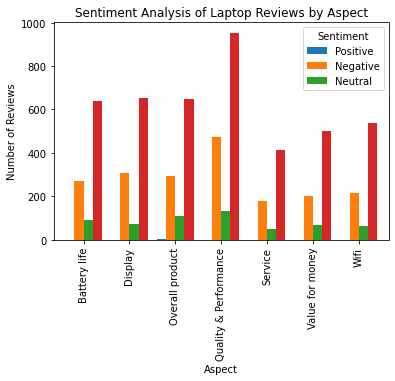

In [86]:
# Plotting the number of positive, negative, and neutral reviews for each of the 7 aspects

import pandas as pd
import matplotlib.pyplot as plt

# Group the dataset by aspect and sentiment score
grouped = laptop.groupby(['Dominant Topic Name', 'Sentiment'])

# Count the number of reviews for each aspect and sentiment score
counts = grouped.size().unstack(fill_value=0)

# Plot the counts for each aspect and sentiment score
counts.plot(kind='bar', width=0.8)

# Set the plot title and labels
plt.title('Sentiment Analysis of Laptop Reviews by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')

# Set the x-axis labels
x_labels = counts.index
plt.xticks(range(len(x_labels)), x_labels)

# Add legend
plt.legend(title='Sentiment', loc='upper right', labels=['Positive', 'Negative', 'Neutral'])

# Display the plot
plt.show()

#From above graph, we see that people are talking more about overall quality and performance -- this characteristic got highest number of reviews followed by display and battery life <br>
#Value for money aspect got least negatuve reviews<br>
#To extend this project, we can plot the graph product wise 

In [84]:
# Thus, by combining these two approaches we can find out sentiment and characteristics of a laptop review
#Given a review, the LDA would provide dominant topic while RNN model would provide its sentiment, 
#the business would understand which areas they are good and which areas need improvements